In [111]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pyperclip

In [112]:
dt = 0.1
s  = ctl.TransferFunction.s

In [113]:
G = 1/(s**2 + 2*s)
C = (21.9543820023537*s + 64.585390060199)/(1.0*s + 5.35662298681269)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([21.954382  , 64.58539006]), array([ 1.        ,  7.35662299, 32.66762798, 64.58539006]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [114]:
G_z = ctl.c2d(G, dt, method='zoh')
G_z

TransferFunction(array([0.00468269, 0.00438077]), array([ 1.        , -1.81873075,  0.81873075]), 0.1)

In [115]:
C_z = ctl.c2d(C, dt, method='tustin')
C_z

TransferFunction(array([ 19.86356899, -14.76940562]), array([ 1.        , -0.57749713]), 0.1)

In [116]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.0930149 ,  0.01785729, -0.06470143]), array([ 1.        , -2.30321298,  1.88689983, -0.53751609]), 0.1)

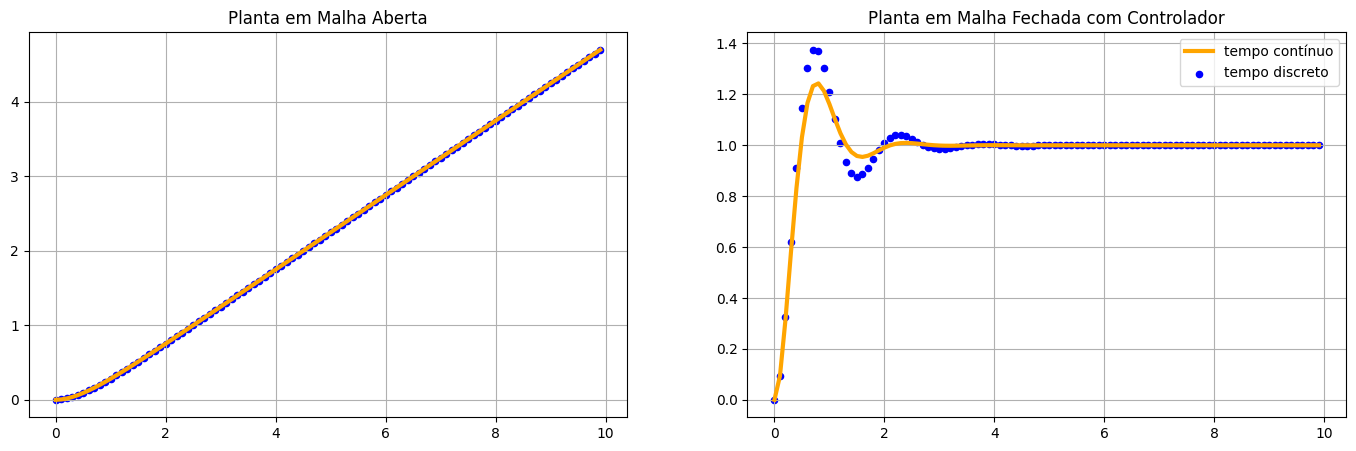

In [117]:
tData = np.arange(0, 10, dt)
plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', s=20, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', s=20, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# DIGITALIZANDO O SISTEMA
- Preparando as funções que permitem digitalizar a função de transferência em transformada $Z$
    - **printDigital**: Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada
    - **compute**: aplica a função digitalizada a partir dos estados anteriores

- Estados anteriores
    - Y[0], Y[1], Y[2] ... se referem aos estados $Y_n$ (saída atual), $Y_{n-1}$ (penúltima saída), $Y_{n-2}$ (antipenúltima saída)

In [118]:
def getFraction(G_z):
    num, den = ctl.tfdata(G_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    num = [float(val) for val in num]
    den = [float(val) for val in den]
    return (num, den) 


num, den = getFraction(G_z)
print(f'num -> xSize={len(num)}')
print(f'den -> ySize={len(den)}')

num -> xSize=2
den -> ySize=3


In [119]:
def printDigital(num, den):
    out = ''
    
    for i in range(0, len(num)): 
        out += f'Xn[{i}]*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Yn[{i}]*({-1*den[i]:.6f}) + '
    
    out = out.replace('X_n0', 'X_n')[:-3]
    print('Y[0] =', out)
    pyperclip.copy(out + ';')


printDigital(num, den)

Y[0] = Xn[0]*(0.004683) + Xn[1]*(0.004381) + Yn[1]*(1.818731) + Yn[2]*(-0.818731)


# OBJETO SISTEMA

In [120]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
        
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [121]:
class DigitalSystem:
    def __init__(self, num, den, dt=0.05, bounds=None):
        self.bounds = bounds if bounds is not None else (-9e12, 9e12)
        self.num = num
        self.den = den
        self.dt  = dt
        self.Xn  = StatesUpdater(size=len(num))
        self.Yn  = StatesUpdater(size=len(den))

    def compute(self):
        out = 0.0
        
        for i in range(0, self.Xn.size): 
            out += self.Xn.buffer[i]*(self.num[i])
        
        for i in range(1, self.Yn.size):
            out += self.Yn.buffer[i]*(-1*self.den[i])
        
        if out > self.bounds[1]:
            out = self.bounds[1]
        
        if out < self.bounds[0]:
            out = self.bounds[0]
        
        return out

    def update(self, input):
        self.Xn.update(input)
        self.Yn.update()

        output = self.compute()
        self.Yn.setFirst(output)
        return output
    
    def control(self, input, setpoint):
        return self.update(setpoint - input)
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()
    

system = DigitalSystem(num, den, dt)

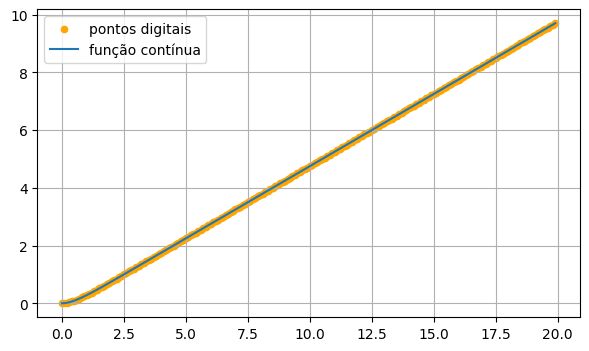

In [122]:
time    = np.arange(0, 20, dt)
digital = [0.0]  # pois no t=0 a saída é zero
for k in range(1, len(time)):
    digital.append(system.update(1))

time, continuous = ctl.step_response(G, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# DIGITALIZANDO O CONTROLADOR
- Comparando os dados contínuo e digital de forma gráfica através de um step

In [123]:
num, den = getFraction(C_z)
printDigital(num, den)

controller = DigitalSystem(num, den) 

Y[0] = Xn[0]*(19.863569) + Xn[1]*(-14.769406) + Yn[1]*(0.577497)


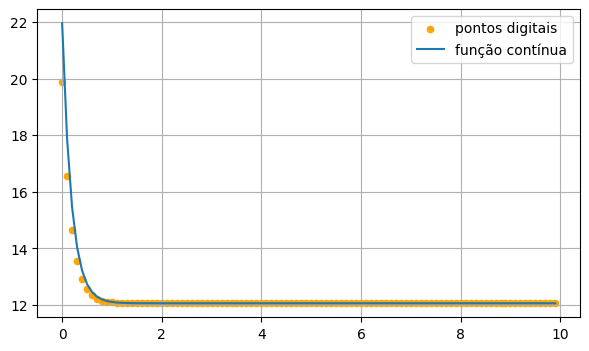

In [124]:
time = np.arange(0, 10, dt)
digital = [controller.control(input=1, setpoint=2) for t in time]
time, continuous = ctl.step_response(C, T=time)

plt.figure(figsize=(7, 4))
plt.scatter(time, digital, label='pontos digitais', color='orange', s=20)
plt.plot(time, continuous, label='função contínua')
plt.grid(), plt.legend()
plt.show()

# SIMULANDO SISTEMA
- O controlador envia um sinal $out$ para a planta, que gera um outro sinal, que é comparado com o setpoint e enviado de novo ao controlador

In [125]:
system     = DigitalSystem(*getFraction(G_z), dt)
controller = DigitalSystem(*getFraction(C_z), dt, bounds=(-5, 10))

In [126]:
class Feedback:
    def __init__(self, system, controller, dt):
        self.system = system
        self.controller = controller
        self.dt = dt
        self.reset()

    def predict(self, input, setpoint):
        Y = self.controller.control(input, setpoint)
        X = self.system.update(Y)
        return X, Y
    
    def simulate(self, uData):
        xData  = np.zeros_like(uData)
        yData  = np.zeros_like(uData)
        output = uData[0]

        for i, setpoint in enumerate(uData):
            X, Y = self.predict(output, setpoint)
            xData[i] = X
            yData[i] = Y
            output = X
        
        return xData, yData
    
    def simulateResponse(self, uData):
        xData  = np.zeros_like(uData)
        yData  = np.zeros_like(uData)
        output = uData[0]

        for i, setpoint in enumerate(uData):
            X, Y = self.predict(output, setpoint)
            xData[i] = X
            yData[i] = Y
            output = X

        return xData, yData
    
    def reset(self):
        self.system.reset(), self.controller.reset()
        
    
feedback = Feedback(system, controller, dt)

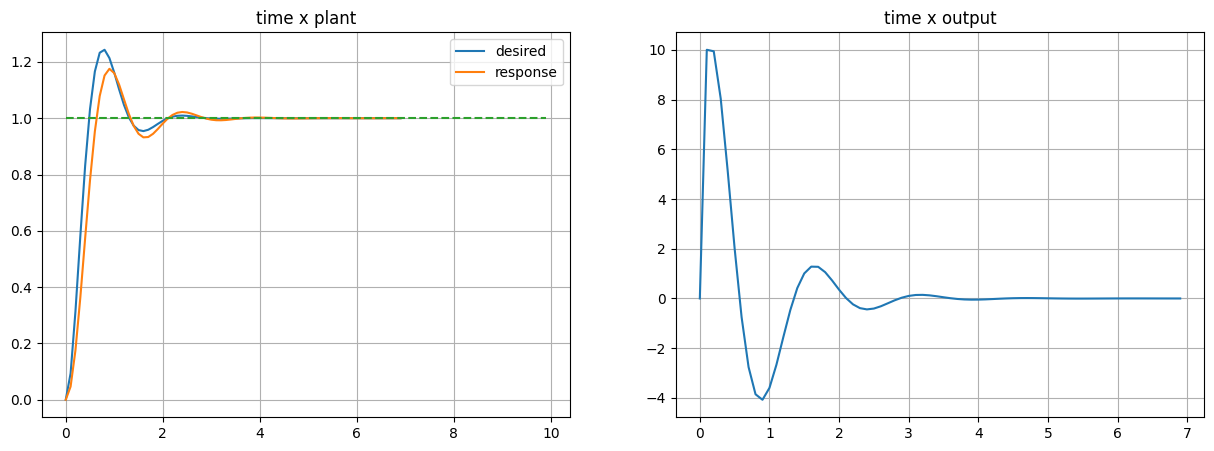

In [127]:
feedback.reset()
time  = np.arange(0, 7, dt)
uData = np.ones_like(time)
setpoint = uData[0]

desired = ctl.step_response(setpoint*G_feedback, T=time)[1]
response, output = feedback.simulate(uData)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(time, desired, label='desired')
plt.plot(time, response, label='response')
plt.plot(tData, [setpoint for i in tData], '--')
plt.title('time x plant')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(time, output)
plt.title('time x output')
plt.grid()